In [1]:
# imports

import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

# Define new bounding boxes for cases where image basis changes

Note: point rotations, filtering preserves the original coordinates of the target object, no need to redefine bounding boxes after augmentation

image label(s): `<class_id> <x_center> <y_center> <width> <height>`
-  All values of bounding box related to image are normalized by image width and height (values between 0 and 1).


### parse label items

In [2]:
def parse_label_string(label_string):
    """
    Parses a YOLO label string into components.
    
    Parameters:
    - label_string: str, format '<class_id> <x_center> <y_center> <width> <height>'
    
    Returns:
    - (class_id, x_center, y_center, width, height): tuple with class_id as str, others as floats
    """
    parts = label_string.strip().split()
    class_id = parts[0]
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])
    return class_id, x_center, y_center, width, height

def format_label(class_id, x_center, y_center, width, height):
    """
    Formats label components back into YOLO string format.
    """
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

### bounding boxes for reflections

In [3]:
def reflect_over_x_bbox(label_strings):
    """
    Reflects each bounding box over the x-axis (vertical flip) in a list.
    """
    reflected = []
    for label in label_strings:
        class_id, x_center, y_center, width, height = parse_label_string(label)
        new_y_center = 1.0 - y_center
        reflected.append(format_label(class_id, x_center, new_y_center, width, height))
    return reflected

In [4]:
def reflect_over_y_bbox(label_strings):
    """
    Reflects each bounding box over the y-axis (horizontal flip) in a list.
    """
    reflected = []
    for label in label_strings:
        class_id, x_center, y_center, width, height = parse_label_string(label)
        new_x_center = 1.0 - x_center
        reflected.append(format_label(class_id, new_x_center, y_center, width, height))
    return reflected

### bounding boxes for rotations

In [ ]:
def rotate_bbox(label_string, image_shape, angle):
    """
    Apply rotation to a YOLO bounding box and return the updated YOLO-format string.

    Parameters:
    - label_string: str, YOLO format '<class_id> <x_center> <y_center> <width> <height>'
    - image_shape: tuple, (height, width)
    - angle: rotation angle in degrees

    Returns:
    - new_label_string: str, updated bounding box in YOLO format
    """
    class_id, xc, yc, w, h = parse_label_string(label_string)
    img_h, img_w = image_shape

    # convert normalized to absolute coordinates
    xc *= img_w
    yc *= img_h
    w *= img_w
    h *= img_h

    # get original corners
    x1 = xc - w / 2
    y1 = yc - h / 2
    x2 = xc + w / 2
    y2 = yc + h / 2
    corners = np.array([
        [x1, y1],
        [x1, y2],
        [x2, y1],
        [x2, y2]
    ])

    # rotation center
    cx, cy = img_w // 2, img_h // 2

    # rotate corners
    theta = math.radians(angle)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)

    rotated_corners = []
    for x, y in corners:
        xt = x - cx
        yt = y - cy
        xr = cos_theta * xt - sin_theta * yt + cx
        yr = sin_theta * xt + cos_theta * yt + cy
        rotated_corners.append([xr, yr])

    rotated_corners = np.array(rotated_corners)

    # compute axis-aligned bounding box
    x_min, y_min = rotated_corners.min(axis=0)
    x_max, y_max = rotated_corners.max(axis=0)

    # Clip the new bounding box coordinates to ensure they stay within image bounds
    x_min = max(0, min(x_min, img_w - 1))
    x_max = max(0, min(x_max, img_w - 1))
    y_min = max(0, min(y_min, img_h - 1))
    y_max = max(0, min(y_max, img_h - 1))

    # convert back to normalized coordinates
    new_xc = (x_min + x_max) / 2 / img_w
    new_yc = (y_min + y_max) / 2 / img_h
    new_w = (x_max - x_min) / img_w
    new_h = (y_max - y_min) / img_h

    return format_label(class_id, new_xc, new_yc, new_w, new_h)

def rotate_bboxes(label_strings, image_shape, angle_degrees):
    """
    Rotates each bounding box in a list of YOLO-format label strings.
    
    Parameters:
    - label_strings: list of str, YOLO format '<class_id> <x_center> <y_center> <width> <height>'
    - image_shape: tuple, (height, width) of the image
    - angle_degrees: float, angle to rotate (clockwise)
    
    Returns:
    - new_label_strings: list of str, new YOLO-format bounding boxes
    """
    return [rotate_bbox(label, image_shape, angle_degrees) for label in label_strings]

### bounding boxes for shears

In [6]:
def shear_bbox(label_string, image_shape, shear_factor_x=0.0, shear_factor_y=0.0):
    """
    Apply shear to a YOLO bounding box and return the updated YOLO-format string.

    Parameters:
    - label_string: str, YOLO format '<class_id> <x_center> <y_center> <width> <height>'
    - image_shape: tuple, (height, width)
    - shear_factor_x: horizontal shear factor
    - shear_factor_y: vertical shear factor

    Returns:
    - new_label_string: str, updated bounding box in YOLO format
    """
    class_id, xc, yc, w, h = parse_label_string(label_string)
    img_h, img_w = image_shape

    # convert normalized to absolute coordinates
    xc *= img_w
    yc *= img_h
    w *= img_w
    h *= img_h

    # get original corners
    x1 = xc - w / 2
    y1 = yc - h / 2
    x2 = xc + w / 2
    y2 = yc + h / 2
    corners = np.array([
        [x1, y1],
        [x1, y2],
        [x2, y1],
        [x2, y2]
    ])

    # apply shear transformation
    sheared = []
    for x, y in corners:
        new_x = x + shear_factor_x * y
        new_y = y + shear_factor_y * x
        sheared.append([new_x, new_y])

    sheared = np.array(sheared)

    # compute axis-aligned bounding box
    x_min, y_min = sheared.min(axis=0)
    x_max, y_max = sheared.max(axis=0)

    # Clip the new bounding box coordinates to ensure they stay within image bounds
    x_min = max(0, min(x_min, img_w - 1))
    x_max = max(0, min(x_max, img_w - 1))
    y_min = max(0, min(y_min, img_h - 1))
    y_max = max(0, min(y_max, img_h - 1))

    # convert back to normalized coordinates
    new_xc = (x_min + x_max) / 2 / img_w
    new_yc = (y_min + y_max) / 2 / img_h
    new_w = (x_max - x_min) / img_w
    new_h = (y_max - y_min) / img_h

    return format_label(class_id, new_xc, new_yc, new_w, new_h)

def shear_bboxes(label_strings, image_shape, shear_factor_x=0.0, shear_factor_y=0.0):
    """
    Applies shear transformation to each bounding box in a list of YOLO-format label strings.

    Parameters:
    - label_strings: list of str, YOLO format '<class_id> <x_center> <y_center> <width> <height>'
    - image_shape: tuple, (height, width)
    - shear_factor_x: horizontal shear factor
    - shear_factor_y: vertical shear factor

    Returns:
    - new_label_strings: list of str, updated bounding boxes in YOLO format
    """
    return [shear_bbox(label, image_shape, shear_factor_x, shear_factor_y) for label in label_strings]

## Test

In [7]:
# Load the image using OpenCV (note: this loads in BGR format)
img = cv2.imread('motorcycle.jpg')
# Convert BGR to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert to numpy array for processing
img_array = np.array(img_rgb)
# label
label = "3 0.5060096153846154 0.5432692307692307 0.9699519230769231 0.8221153846153846"

In [8]:
# augmentation functions

def rotate_image(image, angle):
    """
    Rotate the image by a given angle.
    Parameters:
    - image: 2D numpy array representing the input image
    - angle: angle in degrees to rotate the image
    Returns:
    - rotated_image: 2D numpy array representing the rotated image
    """
    if angle == 0:
        return image

    # Get image dimensions
    height, width = image.shape[:2]
    rotated_image = np.zeros_like(image)

    # Convert angle to radians
    theta = math.radians(angle)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)

    # Rotation center
    cx, cy = width // 2, height // 2

    for y in range(height):
        for x in range(width):
            # shift to origin
            xt = x - cx
            yt = y - cy

            # apply rotation
            xr = cos_theta * xt - sin_theta * yt
            yr = sin_theta * xt + cos_theta * yt

            # shift back
            src_x = int(round(xr + cx))
            src_y = int(round(yr + cy))

            # if within bounds, assign pixel
            if 0 <= src_x < width and 0 <= src_y < height:
                rotated_image[y, x] = image[src_y, src_x]

    return rotated_image

def reflect_image(image, axis):
    """
    Reflect the image across a given axis.
    Parameters:
    - image: 2D numpy array representing the input image
    - axis: 'horizontal' or 'vertical' to specify the reflection axis
    Returns:
    - reflected_image: 2D numpy array representing the reflected image
    """
    if axis == 'x':  # vertical flip
        flipped_image = image[::-1, ...]  # reverse rows
    elif axis == 'y':  # horizontal flip
        flipped_image = image[:, ::-1, ...]  # reverse columns

    return flipped_image

def shear_image(image, shear_factor_x=0, shear_factor_y=0):
    """
    Shear an image in the X or Y direction using a manual approach.
    
    Parameters:
    - image: np.ndarray (H x W x C or H x W)
    - shear_factor_x: shear factor for horizontal slant
    - shear_factor_y: shear factor for vertical slant
    
    Returns:
    - sheared_image: np.ndarray (sheared image)
    """
    height, width = image.shape[:2]
    
    # create larger canvas to accommodate shearing
    enlarged_height = height + abs(int(shear_factor_y * width))
    enlarged_width = width + abs(int(shear_factor_x * height))
    enlarged_image = np.zeros((enlarged_height, enlarged_width, 3), dtype=image.dtype)
    
    # apply shearing transformations (map to larger canvas)
    for y in range(height):
        for x in range(width):
            new_x = int(x + shear_factor_x * y)
            new_y = int(y + shear_factor_y * x)
            if 0 <= new_x < enlarged_width and 0 <= new_y < enlarged_height:
                enlarged_image[new_y, new_x] = image[y, x]
    
    # scale transformation back to original size
    sheared_image = cv2.resize(enlarged_image, (width, height), interpolation=cv2.INTER_LINEAR)

    return sheared_image

# apply shear
shear_x = shear_image(img_rgb, shear_factor_x=0.25)  # shear in x direction
shear_y = shear_image(img_rgb, shear_factor_y=0.33)  # shear in y direction

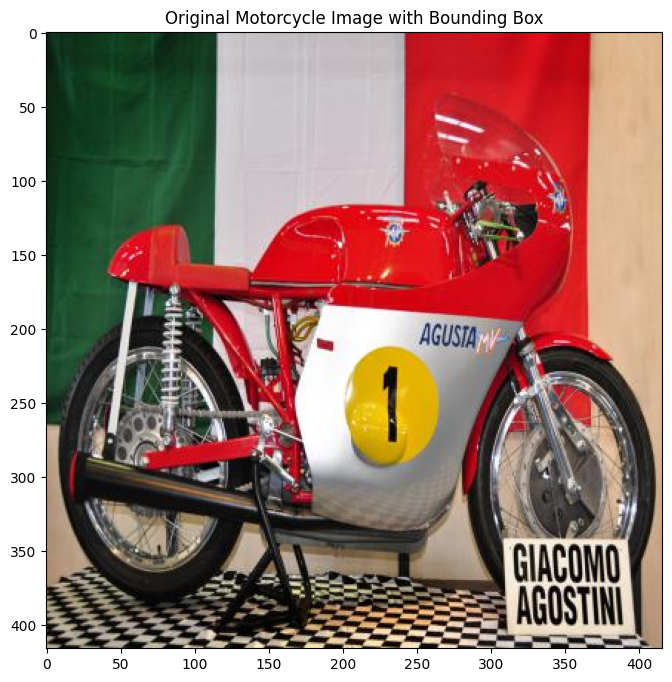

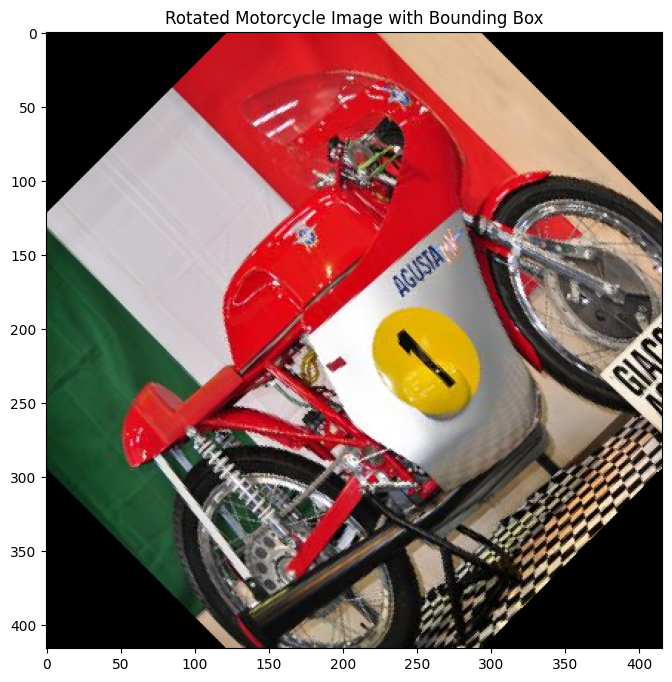

In [11]:
rotation_angle = 45  # Angle to rotate the image (in degrees)

# Apply rotation to the image
rotated_image = rotate_image(img_rgb, rotation_angle)

# Apply rotation to the bounding box
image_shape = img_rgb.shape[:2]  # Get the image shape (height, width)
new_label = rotate_bbox(label, image_shape, rotation_angle)

# Parse the new label and draw the updated bounding box
class_id, xc, yc, w, h = parse_label_string(new_label)
img_h, img_w = image_shape

# Convert normalized coordinates back to absolute values
x_center = xc * img_w
y_center = yc * img_h
width = w * img_w
height = h * img_h

# Calculate the corner points of the bounding box
x1 = x_center - width / 2
y1 = y_center - height / 2
x2 = x_center + width / 2
y2 = y_center + height / 2

# Draw the original bounding box on the original image
img_copy = img_rgb.copy()
cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)

# Draw the rotated bounding box on the rotated image
rotated_image_copy = rotated_image.copy()
cv2.rectangle(rotated_image_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)

# Display the original image with bounding box
plt.figure(figsize=(10, 8))
plt.imshow(img_copy)
plt.title('Original Motorcycle Image with Bounding Box')
plt.axis('on')
plt.show()

# Display the rotated image with bounding box
plt.figure(figsize=(10, 8))
plt.imshow(rotated_image_copy)
plt.title('Rotated Motorcycle Image with Bounding Box')
plt.axis('on')
plt.show()

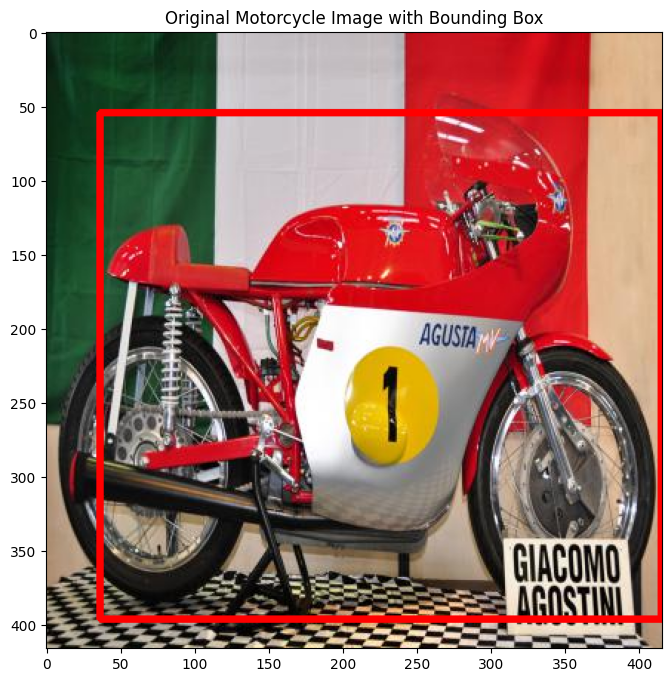

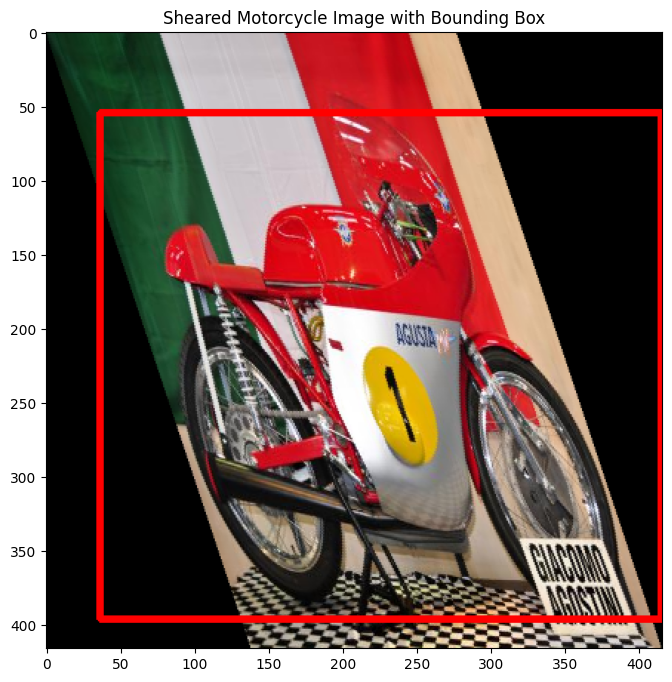

In [10]:
# shear parameters
shear_factor_x = 0.5  # Horizontal shear factor
shear_factor_y = 0  # Vertical shear factor

# Apply shear to the image
sheared_image = shear_image(img_rgb, shear_factor_x=shear_factor_x, shear_factor_y=shear_factor_y)

# Apply shear to the bounding box
image_shape = img_rgb.shape[:2]  # Get the image shape (height, width)
new_label = shear_bbox(label, image_shape, shear_factor_x, shear_factor_y)

# Parse the new label and draw the updated bounding box
class_id, xc, yc, w, h = parse_label_string(new_label)
img_h, img_w = image_shape

# Convert normalized coordinates back to absolute values
x_center = xc * img_w
y_center = yc * img_h
width = w * img_w
height = h * img_h

# Calculate the corner points of the bounding box
x1 = x_center - width / 2
y1 = y_center - height / 2
x2 = x_center + width / 2
y2 = y_center + height / 2

# Draw the original bounding box on the original image
img_copy = img_rgb.copy()
cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)

# Draw the sheared bounding box on the sheared image
sheared_image_copy = sheared_image.copy()
cv2.rectangle(sheared_image_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)

# Display the original image with bounding box
plt.figure(figsize=(10, 8))
plt.imshow(img_copy)
plt.title('Original Motorcycle Image with Bounding Box')
plt.axis('on')
plt.show()

# Display the sheared image with bounding box
plt.figure(figsize=(10, 8))
plt.imshow(sheared_image_copy)
plt.title('Sheared Motorcycle Image with Bounding Box')
plt.axis('on')
plt.show()